In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Load the data

data = pd.read_csv('class.csv')

In [2]:
# Remove Duplicates
data = data.drop_duplicates()
print(f"\nAfter removing duplicates: {data.shape}")


After removing duplicates: (3233, 8)


In [3]:
# Handlind Missing Values
data = data.copy()  # تجنب SettingWithCopyWarning
num_cols_all = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = data.select_dtypes(include=['object']).columns.tolist()

for col in num_cols_all:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

for col in cat_cols_all:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

In [4]:
# handling outliers
def remove_outliers_iqr(df, columns):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

In [5]:
continuous_cols = ['forehead_width_cm', 'forehead_height_cm']
data = remove_outliers_iqr(data, continuous_cols)
print(f"\nAfter removing outliers: {data.shape}")


After removing outliers: (3233, 8)


In [6]:
target_column = "gender"

# Encode target
le = LabelEncoder()
y = le.fit_transform(data[target_column])
print(f"\nTarget classes: {le.classes_}")


Target classes: ['Female' 'Male']


In [7]:
# Create features
X = data.drop(columns=[target_column])

In [8]:
num_cols = ['forehead_width_cm', 'forehead_height_cm']

In [9]:
binary_cols = ['long_hair', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']

print(f"\nNumerical columns: {num_cols}")
print(f"Binary columns: {binary_cols}")


Numerical columns: ['forehead_width_cm', 'forehead_height_cm']
Binary columns: ['long_hair', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'  
)

In [11]:
def build_pipeline (num_cols):
   
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols)
        ],
        remainder='passthrough'  
    )

In [12]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ))
])

In [13]:
#train /test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (2586, 7)
Test set: (647, 7)


In [14]:
#training
model.fit(X_train, y_train)

C:\Users\ahmad\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['forehead_width_cm',
                                                   'forehead_height_cm'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [15]:
print("\n" + "="*50)
print("Cross-Validation")
print("="*50)

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



Cross-Validation
CV Scores: [0.95826893 0.96445131 0.95517774 0.96130031 0.95356037]
Mean CV Accuracy: 0.9586 (+/- 0.0040)


In [16]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"\nAccuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")


TEST SET EVALUATION

Classification Report:
              precision    recall  f1-score   support

      Female       0.96      0.94      0.95       290
        Male       0.95      0.97      0.96       357

    accuracy                           0.96       647
   macro avg       0.96      0.96      0.96       647
weighted avg       0.96      0.96      0.96       647


Accuracy: 0.9567
AUC Score: 0.9918


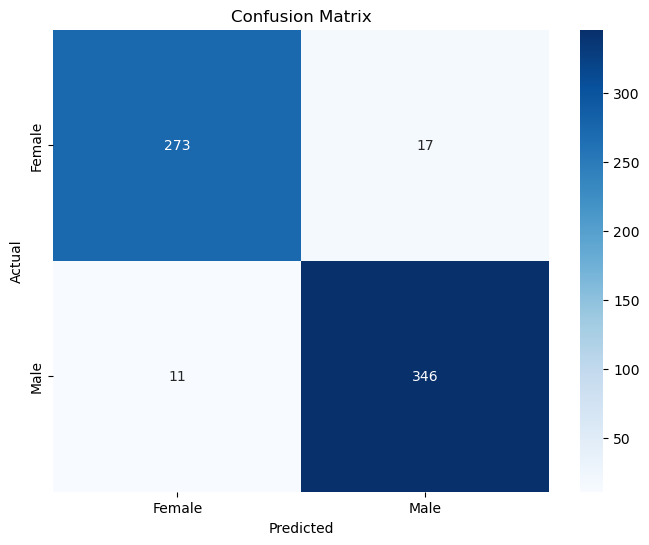

In [17]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

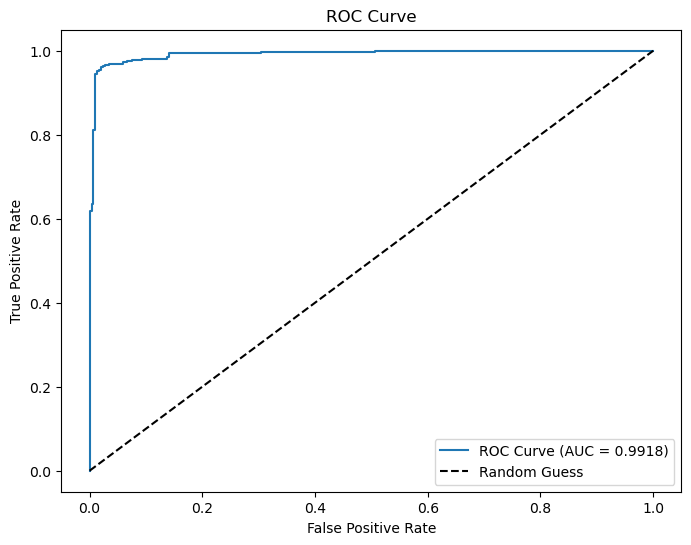

In [18]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Feature Importance
importances = model.named_steps['classifier'].feature_importances_
all_features = num_cols + binary_cols

feature_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20836\1530117465.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp, x='importance', y='feature', palette='viridis')


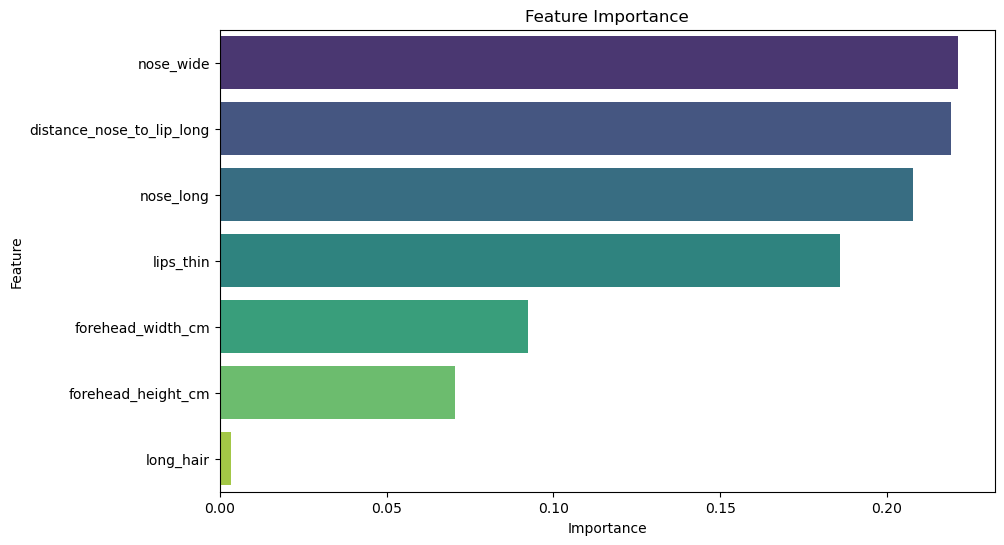

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_imp, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print("\nTop 3 Most Important Features:")
print(feature_imp.head(3))


Top 3 Most Important Features:
                     feature  importance
3                  nose_wide    0.221173
6  distance_nose_to_lip_long    0.219063
4                  nose_long    0.207759


In [23]:
# saving the model

import os
os.makedirs('models', exist_ok=True)

# encoder
joblib.dump(model, 'models/gender_classifier_model.pkl')
joblib.dump(le, 'models/label_encoder.pkl')

print("\n✓ Model and encoder saved successfully!")
print(f"  - Model saved to: models/gender_classifier_model.pkl")
print(f"  - Encoder saved to: models/label_encoder.pkl")



✓ Model and encoder saved successfully!
  - Model saved to: models/gender_classifier_model.pkl
  - Encoder saved to: models/label_encoder.pkl
